In [1]:
!sudo add-apt-repository ppa:deadsnakes/ppa -y
!sudo apt-get update -y
!sudo apt-get install python3.12 python3.12-venv python3.12-dev -y
!sudo update-alternatives --install /usr/bin/python3 python3 /usr/bin/python3.10 1
!sudo update-alternatives --install /usr/bin/python3 python3 /usr/bin/python3.12 2
!sudo update-alternatives --set python3 /usr/bin/python3.12
!python3 -m ensurepip
!python3 -m pip install --upgrade pip
!python -V

Repository: 'deb https://ppa.launchpadcontent.net/deadsnakes/ppa/ubuntu/ jammy main'
Description:
This PPA contains more recent Python versions packaged for Ubuntu.

Disclaimer: there's no guarantee of timely updates in case of security problems or other issues. If you want to use them in a security-or-otherwise-critical environment (say, on a production server), you do so at your own risk.

Update Note
Please use this repository instead of ppa:fkrull/deadsnakes.

Reporting Issues

Issues can be reported in the master issue tracker at:
https://github.com/deadsnakes/issues/issues

Supported Ubuntu and Python Versions

- Ubuntu 20.04 (focal) Python3.5 - Python3.7, Python3.9 - Python3.13
- Ubuntu 22.04 (jammy) Python3.7 - Python3.9, Python3.11 - Python3.13
- Ubuntu 24.04 (noble) Python3.7 - Python3.11, Python3.13
- Note: Python2.7 (focal, jammy), Python 3.8 (focal), Python 3.10 (jammy), Python3.12 (noble) are not provided by deadsnakes as upstream ubuntu provides those packages.

Why some

In [6]:
import math
import numpy as np
import pandas as pd

import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader
from einops import rearrange
from torch.autograd import Function

import yfinance as yf
from sklearn.preprocessing import MinMaxScaler

import matplotlib.pyplot as plt
import matplotlib.dates as mdates
import matplotlib.ticker as ticker

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

In [3]:
TICKER      = 'ETH-USD'
PERIOD      = '1y'
INTERVAL    = '1h'
WINDOW_SIZE = 60
HORIZON     = 12

df = yf.download(TICKER, period=PERIOD, interval=INTERVAL)[['Close']].dropna()

scaler = MinMaxScaler((0,1))
values = scaler.fit_transform(df.values)  # (N,1)

X, y = [], []
for i in range(len(values) - WINDOW_SIZE):
    X.append(values[i:i+WINDOW_SIZE])
    y.append(values[i+WINDOW_SIZE])
X = np.array(X)  # (samples,60,1)
y = np.array(y)  # (samples,1)

split = int(0.8 * len(X))
X_train, X_val = X[:split], X[split:]
y_train, y_val = y[:split], y[split:]

X_train_t = torch.from_numpy(X_train).float().to(device)
y_train_t = torch.from_numpy(y_train).float().to(device)
X_val_t   = torch.from_numpy(X_val).float().to(device)
y_val_t   = torch.from_numpy(y_val).float().to(device)

YF.download() has changed argument auto_adjust default to True


[*********************100%***********************]  1 of 1 completed


In [4]:
class OneStepTS(Dataset):
    def __init__(self, X, y):
        self.X, self.y = X, y
    def __len__(self):
        return len(self.X)
    def __getitem__(self, i):
        return self.X[i], self.y[i]

bs = 64
train_dl = DataLoader(OneStepTS(X_train_t, y_train_t), batch_size=bs, shuffle=True)
val_dl   = DataLoader(OneStepTS(X_val_t,   y_val_t),   batch_size=bs, shuffle=False)

In [19]:
class CausalConv1D(nn.Module):
    def __init__(self, in_channels, out_channels, kernel_size, dilation=1, **kwargs):
        super().__init__()
        self.padding = (kernel_size - 1) * dilation
        self.conv = nn.Conv1d(in_channels, out_channels, kernel_size,
                              padding=self.padding, dilation=dilation, **kwargs)
    def forward(self, x):
        # x: (B, 1, T) or (B, C, T)
        y = self.conv(x)
        return y[:, :, :-self.padding]

class BlockDiagonal(nn.Module):
    def __init__(self, in_features, out_features, num_blocks):
        super().__init__()
        assert out_features % num_blocks == 0
        self.out_per = out_features // num_blocks
        self.blocks = nn.ModuleList([
            nn.Linear(in_features, self.out_per) for _ in range(num_blocks)
        ])
    def forward(self, x):
        # x: (..., in_features)
        parts = [blk(x) for blk in self.blocks]
        return torch.cat(parts, dim=-1)

class sLSTMBlock(nn.Module):
    def __init__(self, input_size, head_size, num_heads, proj_factor=4/3):
        super().__init__()
        self.input_size = input_size
        self.head_size  = head_size
        self.hidden_size= head_size * num_heads
        self.num_heads  = num_heads

        self.layer_norm = nn.LayerNorm(input_size)
        self.causal_conv= CausalConv1D(1,1,4)

        self.Wz = BlockDiagonal(input_size,  self.hidden_size, num_heads)
        self.Wi = BlockDiagonal(input_size,  self.hidden_size, num_heads)
        self.Wf = BlockDiagonal(input_size,  self.hidden_size, num_heads)
        self.Wo = BlockDiagonal(input_size,  self.hidden_size, num_heads)
        self.Rz = BlockDiagonal(self.hidden_size, self.hidden_size, num_heads)
        self.Ri = BlockDiagonal(self.hidden_size, self.hidden_size, num_heads)
        self.Rf = BlockDiagonal(self.hidden_size, self.hidden_size, num_heads)
        self.Ro = BlockDiagonal(self.hidden_size, self.hidden_size, num_heads)

        self.group_norm = nn.GroupNorm(num_heads, self.hidden_size)
        self.upL = nn.Linear(self.hidden_size, int(self.hidden_size * proj_factor))
        self.upR = nn.Linear(self.hidden_size, int(self.hidden_size * proj_factor))
        self.down= nn.Linear(int(self.hidden_size * proj_factor), input_size)

    def forward(self, x, prev):
        h_prev, c_prev, n_prev, m_prev = prev
        x_norm = self.layer_norm(x)
        x_conv = F.silu(self.causal_conv(x_norm.unsqueeze(1)).squeeze(1))

        z = torch.tanh(self.Wz(x_norm) + self.Rz(h_prev))
        o = torch.sigmoid(self.Wo(x_norm) + self.Ro(h_prev))
        it = self.Wi(x_conv) + self.Ri(h_prev)
        ft = self.Wf(x_conv) + self.Rf(h_prev)

        m_t = torch.max(ft + m_prev, it)
        i   = torch.exp(it   - m_t)
        f   = torch.exp(ft + m_prev - m_t)

        c_t = f * c_prev + i * z
        n_t = f * n_prev + i
        h_t = o * c_t / n_t

        out = self.group_norm(h_t)
        out = self.upL(out) * F.gelu(self.upR(out))
        out = self.down(out)
        final = out + x

        return final, (h_t, c_t, n_t, m_t)

class mLSTMBlock(nn.Module):
    def __init__(self, input_size, head_size, num_heads, proj_factor=2):
        super().__init__()
        self.input_size  = input_size
        self.head_size   = head_size
        self.hidden_size = head_size * num_heads
        self.num_heads   = num_heads

        self.layer_norm = nn.LayerNorm(input_size)
        self.upL = nn.Linear(input_size, int(input_size * proj_factor))
        self.upR = nn.Linear(input_size, self.hidden_size)
        self.skip= nn.Linear(int(input_size * proj_factor), self.hidden_size)
        self.causal_conv = CausalConv1D(1,1,4)

        self.Wq = BlockDiagonal(int(input_size * proj_factor), self.hidden_size, num_heads)
        self.Wk = BlockDiagonal(int(input_size * proj_factor), self.hidden_size, num_heads)
        self.Wv = BlockDiagonal(int(input_size * proj_factor), self.hidden_size, num_heads)
        self.Wi = nn.Linear(int(input_size * proj_factor), self.hidden_size)
        self.Wf = nn.Linear(int(input_size * proj_factor), self.hidden_size)
        self.Wo = nn.Linear(int(input_size * proj_factor), self.hidden_size)

        self.group_norm = nn.GroupNorm(num_heads, self.hidden_size)
        self.down_proj  = nn.Linear(self.hidden_size, input_size)

    def forward(self, x, prev):
        h_prev, c_prev, n_prev, m_prev = prev

        x_norm = self.layer_norm(x)
        xL = self.upL(x_norm)
        xR = self.upR(x_norm)

        x_conv = F.silu(self.causal_conv(xL.unsqueeze(1)).squeeze(1))
        skip   = self.skip(x_conv)

        q = self.Wq(x_conv)
        k = self.Wk(x_conv) / (self.head_size ** 0.5)
        v = self.Wv(xL)

        it = self.Wi(x_conv)
        ft = self.Wf(x_conv)
        o  = torch.sigmoid(self.Wo(xL))

        m_t = torch.max(ft + m_prev, it)
        i   = torch.exp(it   - m_t)
        f   = torch.exp(ft + m_prev - m_t)

        c_t = f * c_prev + i * (v * k)
        n_t = f * n_prev + i * k

        dot_nq = (n_t * q).sum(dim=1, keepdim=True)
        denom  = torch.clamp(dot_nq.abs(), min=1.0)

        h_t = o * (c_t * q) / denom

        out = self.group_norm(h_t) + skip
        out = out * F.silu(xR)
        out = self.down_proj(out)
        final = out + x

        return final, (h_t, c_t, n_t, m_t)

class xLSTM(nn.Module):
    def __init__(self, input_size, head_size, num_heads, layers="msm", batch_first=True):
        super().__init__()
        self.batch_first = batch_first
        self.blocks = nn.ModuleList()
        for t in layers:
            if t == 's':
                self.blocks.append(sLSTMBlock(input_size, head_size, num_heads))
            else:
                self.blocks.append(mLSTMBlock(input_size, head_size, num_heads))

    def forward(self, x, state=None):
        # x: (B,T,F) if batch_first
        if self.batch_first:
            x = x.transpose(0, 1)  # -> (T,B,F)
        T, B, F = x.shape

        if state is None:
            state = [(
                torch.zeros(B, blk.hidden_size, device=x.device),
                torch.zeros(B, blk.hidden_size, device=x.device),
                torch.zeros(B, blk.hidden_size, device=x.device),
                torch.zeros(B, blk.hidden_size, device=x.device)
            ) for blk in self.blocks]

        outputs = []
        for t in range(T):
            h = x[t]
            for i, blk in enumerate(self.blocks):
                h, state[i] = blk(h, state[i])
            outputs.append(h)

        out = torch.stack(outputs, dim=0)  # (T,B,F)
        if self.batch_first:
            out = out.transpose(0, 1)       # -> (B,T,F)
        return out, state

In [20]:
n_epochs = 20
learning_rate = 1e-3
batch_size = 64

model = xLSTM(input_size=1, head_size=16, num_heads=4,
              layers="msm", batch_first=True).to(device)
criterion = nn.MSELoss()
optimizer = optim.Adam(model.parameters(), lr=learning_rate)

train_losses, val_losses = [], []

In [21]:
for ep in range(1, n_epochs+1):
    model.train()
    total_tr, total_val = 0.0, 0.0

    for Xb, yb in train_dl:
        optimizer.zero_grad()
        out, _ = model(Xb)             # (B, WINDOW_SIZE, 1)
        pred = out[:, -1, :]           # (B,1)
        loss = criterion(pred, yb)
        loss.backward()
        optimizer.step()
        total_tr += loss.item() * Xb.size(0)

    model.eval()
    with torch.no_grad():
        for Xb, yb in val_dl:
            out, _ = model(Xb)
            pred = out[:, -1, :]
            total_val += criterion(pred, yb).item() * Xb.size(0)

    tr_loss = total_tr / len(train_dl.dataset)
    vl_loss = total_val / len(val_dl.dataset)
    train_losses.append(tr_loss)
    val_losses.append(vl_loss)

    print(f"Epoch {ep:02d}: Train MSE={tr_loss:.6f}, Val MSE={vl_loss:.6f}")

Epoch 01: Train MSE=0.002349, Val MSE=0.000042
Epoch 02: Train MSE=0.000066, Val MSE=0.000043
Epoch 03: Train MSE=0.000066, Val MSE=0.000043
Epoch 04: Train MSE=0.000067, Val MSE=0.000042
Epoch 05: Train MSE=0.000068, Val MSE=0.000045
Epoch 06: Train MSE=0.000069, Val MSE=0.000044
Epoch 07: Train MSE=0.000068, Val MSE=0.000043
Epoch 08: Train MSE=0.000067, Val MSE=0.000042
Epoch 09: Train MSE=0.000067, Val MSE=0.000043
Epoch 10: Train MSE=0.000069, Val MSE=0.000043
Epoch 11: Train MSE=0.000070, Val MSE=0.000048
Epoch 12: Train MSE=0.000073, Val MSE=0.000049
Epoch 13: Train MSE=0.000070, Val MSE=0.000063
Epoch 14: Train MSE=0.000072, Val MSE=0.000049
Epoch 15: Train MSE=0.000074, Val MSE=0.000051
Epoch 16: Train MSE=0.000080, Val MSE=0.000053
Epoch 17: Train MSE=0.000072, Val MSE=0.000045
Epoch 18: Train MSE=0.000072, Val MSE=0.000044
Epoch 19: Train MSE=0.000075, Val MSE=0.000049
Epoch 20: Train MSE=0.000076, Val MSE=0.000081


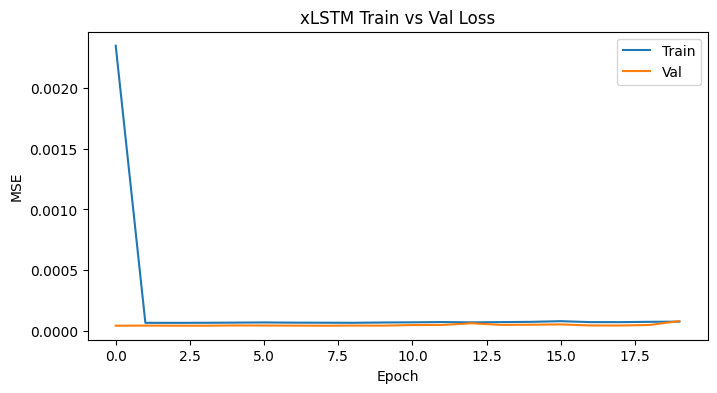

In [22]:
plt.figure(figsize=(8,4))
plt.plot(train_losses, label='Train')
plt.plot(val_losses,   label='Val')
plt.title('xLSTM Train vs Val Loss')
plt.xlabel('Epoch'); plt.ylabel('MSE')
plt.legend(); plt.show()

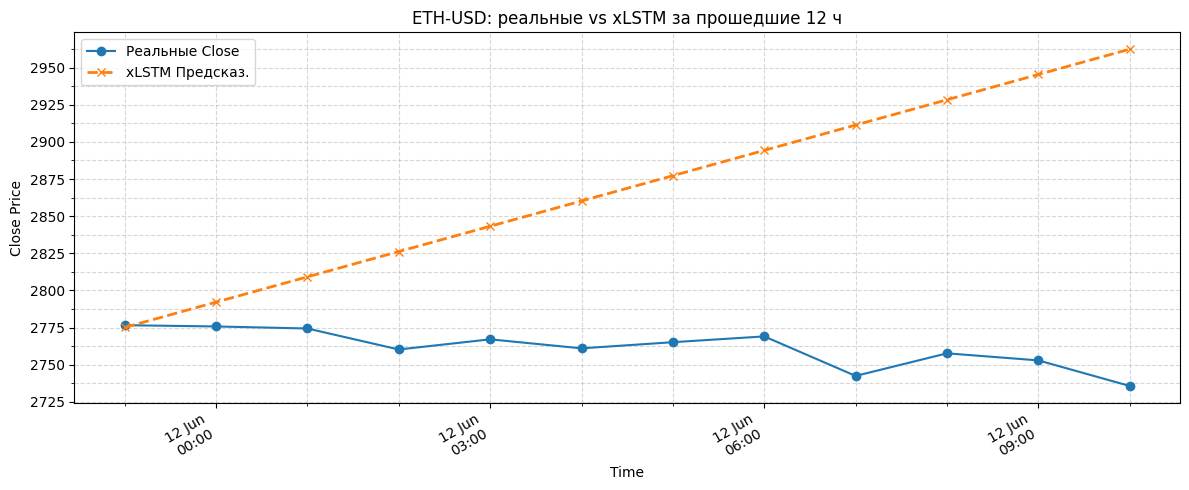

In [23]:
hist_win = values[-WINDOW_SIZE-HORIZON : -HORIZON]
hist_dates = df.index[-HORIZON:]

window = torch.from_numpy(hist_win).float().unsqueeze(0).to(device)
pred_past = []
model.eval()
with torch.no_grad():
    for _ in range(HORIZON):
        out, _ = model(window)
        nxt = out[:, -1, :].cpu().numpy()
        pred_past.append(nxt[0,0])
        window = torch.cat([window[:,1:,:],
                            torch.from_numpy(nxt).float().unsqueeze(1).to(device)],
                           dim=1)

pred_past = scaler.inverse_transform(np.array(pred_past).reshape(-1,1)).flatten()
actual_past = scaler.inverse_transform(values[-HORIZON:].reshape(-1,1)).flatten()

fig, ax = plt.subplots(figsize=(12,5))
ax.plot(hist_dates, actual_past, 'o-', label='Реальные Close', lw=1.5)
ax.plot(hist_dates, pred_past, 'x--', label='xLSTM Предсказ.', lw=2)
ax.xaxis.set_major_locator(mdates.HourLocator(byhour=range(0,24,3)))
ax.xaxis.set_minor_locator(mdates.HourLocator(interval=1))
ax.xaxis.set_major_formatter(mdates.DateFormatter('%d %b\n%H:%M'))
fig.autofmt_xdate(0)
ax.yaxis.set_major_locator(ticker.MaxNLocator(10)); ax.yaxis.set_minor_locator(ticker.AutoMinorLocator(2))
ax.grid(True, which='both', ls='--', alpha=0.5)
ax.set_title('ETH-USD: реальные vs xLSTM за прошедшие 12 ч')
ax.set_xlabel('Time'); ax.set_ylabel('Close Price'); ax.legend(loc='upper left')
plt.tight_layout(); plt.show()

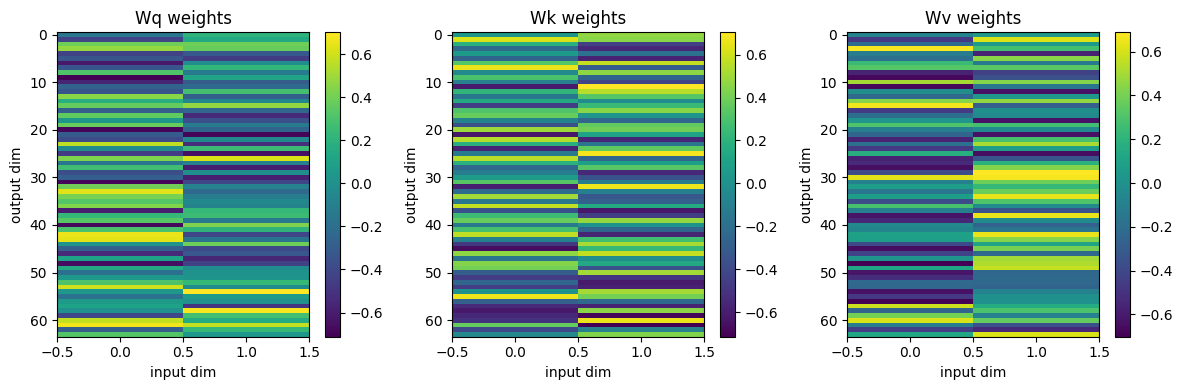

In [24]:
blk = model.blocks[-1]
fig, axes = plt.subplots(1, 3, figsize=(12,4))
for ax, name, mat in zip(axes,
                         ['Wq','Wk','Wv'],
                         [blk.Wq, blk.Wk, blk.Wv]):
    W = torch.cat([b.weight.detach().cpu() for b in mat.blocks], dim=0)
    im = ax.imshow(W, aspect='auto')
    ax.set_title(f'{name} weights')
    ax.set_xlabel('input dim'); ax.set_ylabel('output dim')
    fig.colorbar(im, ax=ax)
plt.tight_layout(); plt.show()

Выводы

1.	Сходимость обучения

  •	Аналогично другим архитектурам, xLSTM тоже очень быстро понижает MSE: уже после 1–2 эпох потери падают с ~0.0023 до 0.0001 и дальше держатся на «низком плато».

  •	Валидизационный лосс почти совпадает с обучающим, что говорит об адекватной обобщающей способности без значительного переобучения.
2.	Реальные vs предсказанные за прошедшие 12 часов

  •	Итеративный мультишаговый прогноз вновь ведёт к монотонному росту предсказаний (от ~2775 до 2960), хотя реальные данные демонстрируют среднесуточный флет с незначительными колебаниями (2775 -> 2735 -> 2755).

  •	Систематическая линейная завышенность прогноза ещё более выражена, чем у Mamba: накопленный bias накапливается в каждом шаге, т.к. модель не обучалась на прямой многовременной цели.
3.	Анализ весов Wq, Wk, Wv последнего mLSTM-блока

  •	Все три матрицы имеют чётко выраженные блоки-головы по горизонтали (по 2 блока) и разнотоновые по вертикали.

  •	Wq (запросы) показывает, что первая половина входных признаков даёт более сильный вклад в запрос, в то время как в Wk и Wv (ключи и значения) вторая половина имеет несколько больших весов.

  •	Это может означать, что xLSTM разделяет пространство фич: одна «группа» каналов отвечает за формирование запроса внимания, а другая – за то, куда и как «смотреть» (ключи/значения).
4.	Плюсы и минусы xLSTM

  •	Плюсы:
      
      •	Быстрая и стабильная сходимость без сложных гиперпараметров.

      •	Гибридный подход: сочетается conv-предобработка, LSTM-механика и «внимание» через Q/K/V.

  •	Минусы:

      •	Кумулятивный bias при итеративном прогнозе усиливается сильнее, чем у Mamba и Transformer.

      •	Отсутствует явный контроль над тем, чтобы модель корректировала линейный дрейф внутри окна.
5.	Идеи для улучшения

  •	Мультишаговый таргетинг (прогноз сразу на 12 шагов) или scheduled sampling, чтобы снизить накопление ошибки.

  •	Регуляризация bias: добавить в loss штраф за смещение среднего прогноза.

  •	Увеличить разнообразие входов: включить объём торгов, технические индикаторы, чтобы разбить линейный дрейф.

  •	Адаптивное смешение: добавить резидуальные связи с прямым входом или механизм внимания, который учитывает не только локальный контекст, но и глобальные паттерны.